# Improving Cars as a Proxy for Shoppers

<img width=50% src=pics/parking_lot.jpg /img>
source of image: https://si.wsj.net/public/resources/images/P1-BO440_REPLIC_P_20131218220538.jpg

We know that there are companies which use satellite images of parking lots, to quantify the 
amount of shoppers at a given client business.

Counting cars is a great first step to quantification, but how about getting closer to actual buying power and conversion ratio ?

$$total\text{ }shoppers \approx \left(\frac{people}{1{car}}\right)(n_{cars})$$

### Fundalmental Question
* How can we better estimate the spending power represented by a car ?

### Let's use another proxy
 * Assume that more people means tendency to higher expenditure
 * Bigger vehicle is a more affluent shopper
 * Bigger vehicles have the ability to transport more or larger items

### How to get vehicle size estimate 
Deep neural networks require training data, which is how a business speciallizing in satellet analysis gets started. 
 
I don't have 5 years of satellite data to re-create the car counting, but that's not interesting to me at the moment anyways, since that problem has been solved.

Machine Learning corner detection or some other dimension detection algorithm might work. However, once again, we'd need training data. 

I propose:
 
* Using a 2D FFT power spectrum, to determine the amount of cars with particular dimensions.


### Experiment
* Take an image of veritally alinged cars in a parking lot.
* Count the number of cars to simulate the ML automated count.
* Perform 2D FFT and use ratios of signal peaks to total car count to estimate vehicle sizes.
* Try to generalize to any orientation of vehicle in a parking lot.


# Technical Considerations
For simplicity sake:
* I'm only using the length dimension
* Using an image sub section with veritcally aligned cars

## Some vehicle lengths
* Chevy Tahoe: $518 cm$
* Toyata Celica: $434 cm$

$\Delta{L}=84 cm$

$k_{nyquist}$ for 90 cm camera = 180 cm. 

I estimated the resolution of the satelite image above, by zooming in on a region with cars.
I counted the numebr of pixels that appear to make up a car and figured that the average car is
$\approx 1.7 m$ in width. 

In [275]:
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
from scipy import fftpack
import radialProfile
%matplotlib inline

data = scipy.ndimage.imread("pics/parking_lot.jpg", flatten=True)

Zoom in enough to count pixels to width. I ount 2 pixels for 1.7 meters

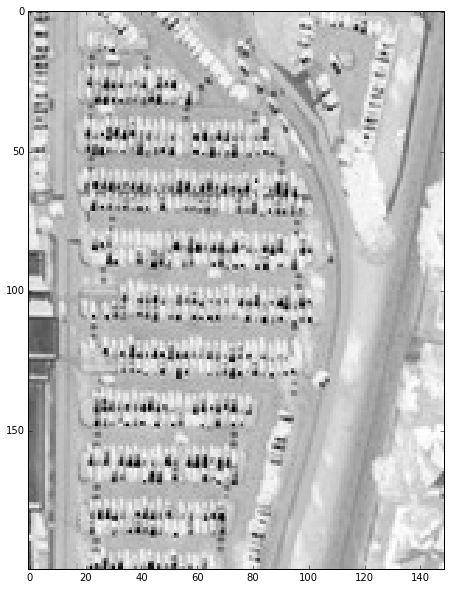

In [358]:
data_sub = data[100:300, 600:800]
plt.figure(figsize=(10, 10))
plt.imshow(data_sub, interpolation='nearest', origin='upper', cmap='Greys')

## Will A Corner Detection Routine Even Work?
I don't know...maybe. Below is my naive anaylsis of the feasibility. Boris and Jason can tell us much better.

In [79]:
import sys
sys.path.append("/home/daniel/git/Python2.7/DataScience/notebooks/orbital")

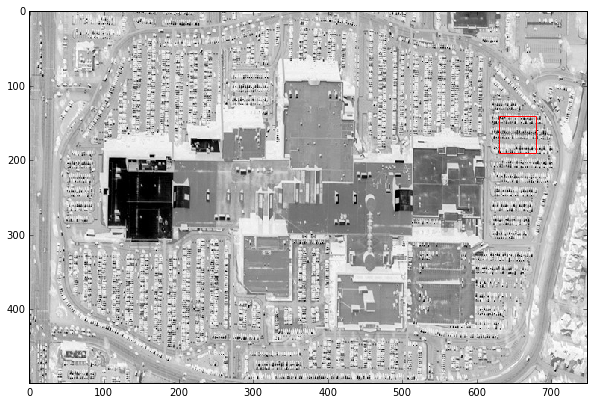

In [351]:
plt.figure(figsize=(10, 10))
plt.imshow(data, interpolation='nearest', origin='upper', cmap='Greys')
plt.hlines(190, 630, 680, 'r')
plt.hlines(140, 630, 680, 'r')
plt.vlines(630, 140, 190, 'r')
plt.vlines(680, 140, 190, 'r')

<matplotlib.colorbar.Colorbar instance at 0x7f3a9974ea28>

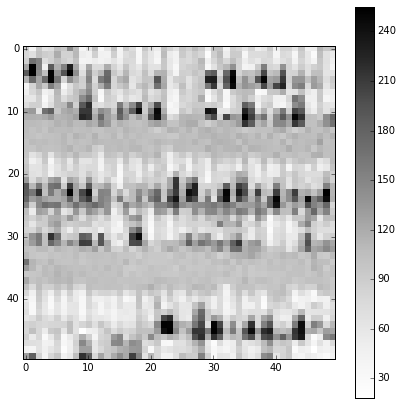

In [370]:
data_sub = data[140:190, 630:680]

plt.figure(figsize=(7, 7))
plt.imshow(data_sub, interpolation='nearest', origin='upper', cmap='Greys')
plt.colorbar()

In [371]:
np.mean([28, 34, 31, 32, 34])

31.800000000000001

In [372]:
def fft2D(data, zoom=1):
    fft = fftpack.fft2(data)
    fft  = fftpack.fftshift(fft)
    power2D = fft.real**2
    half = power2D.shape[0]/2
    if zoom ==1:
        power1D = power2D[:, 0:half].mean(0) 
    else:
        out = power2D[:, 0:half]
        num_splits = data.shape[0] / zoom
        out = scipy.signal.decimate(out, zoom, axis=1)
        return out.mean(1)
            
    power1D *=  0.5 * 1.0/data.shape[0]
    return power1D

In [373]:
## k space scale
def k_scale(dim, npts, zoom=1.0):
    camera_res = 0.30/zoom # m          
    max_len = camera_res * dim #cm , size of sub plot
    nyq = 2 * camera_res #cm
    range_ = max_len - nyq
    # reverse order
    k = np.flipud(np.arange(nyq, max_len,range_/npts))
    return k

In [374]:
zoom = 4.0
data_sub_hires = scipy.ndimage.zoom(data_sub, zoom=zoom, order=3, mode='nearest', prefilter=True)
data_sub_hires = scipy.ndimage.filters.gaussian_filter(data_sub_hires, 3)

<matplotlib.colorbar.Colorbar instance at 0x7f3a98d76d88>

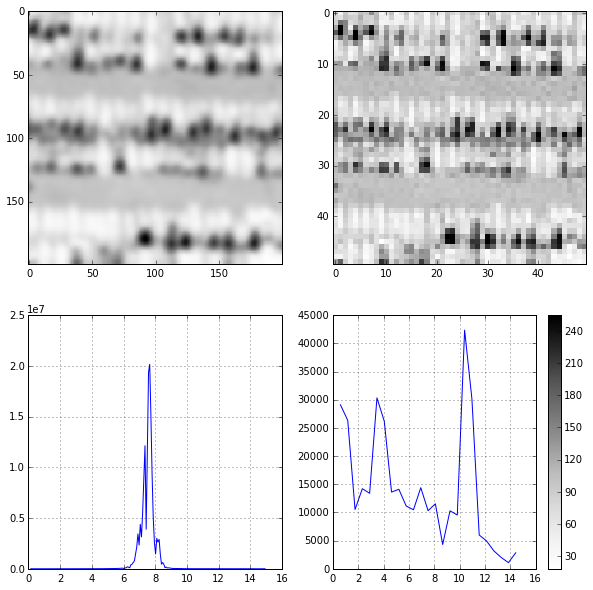

In [375]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(data_sub_hires, interpolation='nearest', origin='upper', cmap='Greys')

plt.subplot(222)
plt.imshow(data_sub, interpolation='nearest', origin='upper', cmap='Greys')

power1D = fft2D(data_sub_hires, zoom=4)
k = k_scale(data_sub_hires.shape[0], power1D.shape[0], zoom=4.0)

plt.subplot(223)
plt.plot(k[:], power1D)
plt.grid()

power1D = fft2D(data_sub)
k = k_scale(data_sub.shape[0], power1D.shape[0])

plt.subplot(224)
plt.plot(k[:], power1D)
plt.grid()
plt.colorbar()

Try again with an edge filter first.

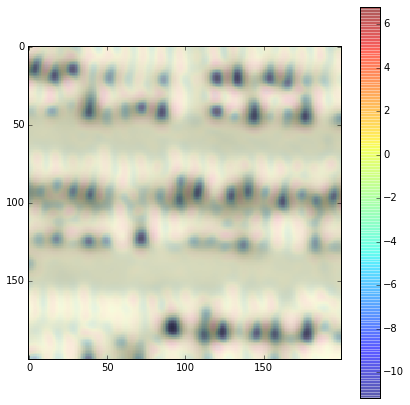

In [390]:
sobel = scipy.ndimage.filters.laplace(data_sub_hires)
sobel[np.isnan(sobel)] = 0

plt.figure(figsize=(7, 7))
plt.imshow(sobel, interpolation='nearest', origin='upper', cmap='jet', alpha=0.4)
plt.colorbar()

plt.imshow(data_sub_hires, interpolation='nearest', origin='upper', cmap='Greys', alpha=0.7)


I'm hoping that the roughly 1.2, 2.25 and 3.1 meter peaks are cars and that means we can classify vehicles by size.

(200, 25)


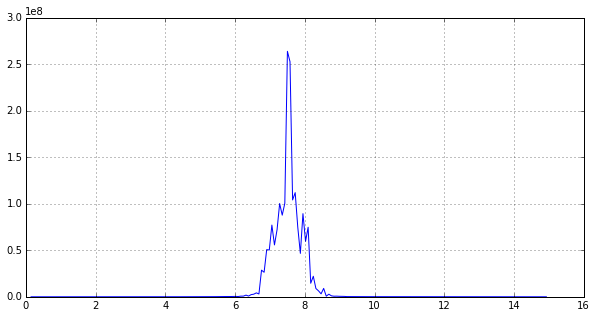

In [367]:
power1D_sobel = fft2D(sobel, zoom=4)
k_sobel = k_scale(sobel.shape[0], power1D_sobel.shape[0], zoom=4.0)
plt.figure(figsize=(10, 5))
plt.plot(k_sobel[:], power1D_sobel)
plt.grid()

In [347]:
total = power1D.sum()

In [348]:
band_3m = np.where((k > 2) & (k <= 4))[0]

In [356]:
power1D[band_3m].sum() / total * 37

6.0826895982027054

# Summary

32 cars with 5 having a dimension of 3 meteres